In [1]:
%matplotlib inline
from __future__ import print_function
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.table import Table
from toolbox.image import img_scale
pixscale = 0.168 # arcsec/pixel
plt.style.use('jpg')

In [2]:
imDIR = '../data/gemini_FT_6-2016/'
c6files = os.listdir(imDIR+'candy_6_cutout')
c6files[1], c6files[2] = c6files[2], c6files[1]
c6files.reverse() # imshow expects RGB
c7files = os.listdir(imDIR+'candy_7_cutout')
c7files[1], c7files[2] = c7files[2], c7files[1]
c7files.reverse()
profDIR = '../data/post_stamp_profiles/'
prof6 = np.loadtxt(profDIR+'candy_6_prof_i.dat')
prof7 = np.loadtxt(profDIR+'candy_7_prof_i.dat')
fitparams = [(4.862,0.0,3.402), (7.5, 0.0, 3.998)]
# distances in Mpc (c6, c7_close, c7_far)
D_A_vals = [125.741, 21.283, 306.706]
D_L_vals = [133.519, 21.497, 356.855]

In [3]:
# rough gaussian and 1D sersic fits to SB profiles
gfits = []
sfits = []
fitter = fitting.LevMarLSQFitter()
gparams = [(5., 0., 3.), (8., 0., 4.)]
sparams = [(5., 6., 0.9), (8., 8., 0.9)]
for i, prof in enumerate([prof6, prof7]):
    _a, _m, _s = gparams[i]
    gauss_init = models.Gaussian1D(amplitude=_a, mean=_m, stddev=_s)
    x = np.concatenate([-prof[:,0], prof[:,0]])
    y = np.concatenate([prof[:,1], prof[:,1]])
    gfits.append(fitter(gauss_init, x, y))
    _a, _r, _n = sparams[i]
    sersic_init = models.Sersic1D(amplitude=_a, r_eff=_r, n=_n)
    sfits.append(fitter(sersic_init, prof[:,0], prof[:,1]))

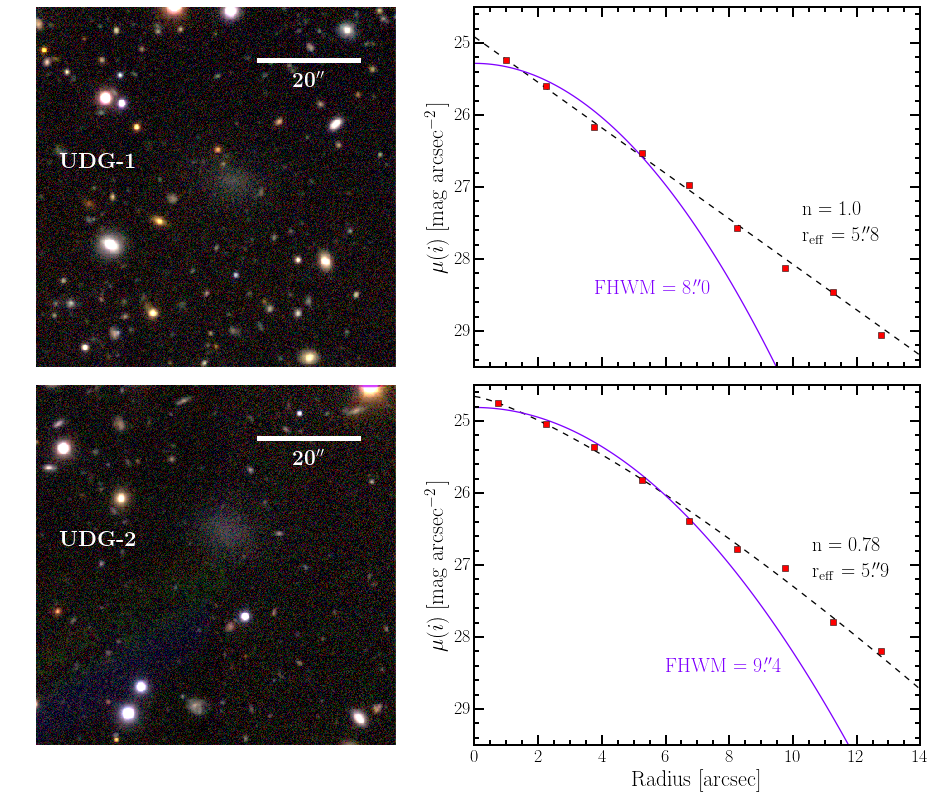

In [4]:
c6 = np.zeros((444, 437, 3))
c7 = np.zeros((451, 463, 3))
c6_max_vals = [0.5, 1.2, 1.9]
c7_max_vals = [0.7, 2.0, 1.2]
min_val = 0.0
cmap = plt.cm.rainbow
for i in range(len(c6files)-1):
    c6_data = fits.getdata(imDIR+'candy_6_cutout/'+c6files[i])
    c7_data = fits.getdata(imDIR+'candy_7_cutout/'+c7files[i])
    max_val = c6_data.mean() + c6_max_vals[i]*c6_data.std()
    c6[:,:,i] = img_scale.sqrt(c6_data, scale_min=min_val, scale_max=max_val)
    max_val = c7_data.mean() + c7_max_vals[i]*c7_data.std()
    c7[:,:,i] = img_scale.sqrt(c7_data, scale_min=min_val, scale_max=max_val)
f, ax = plt.subplots(2, 2, figsize=(16, 12.5))
f.subplots_adjust(hspace=0.05, wspace=0.08)
c6 = c6[:435, :435, :] 
c7 = c7[:435, :435, :] 
y = 370.
xmin = 270.
xmax = xmin + 119
theta = np.linspace(0,14,100)
for i, c, p in zip(range(2), [c6, c7], [prof6, prof7]):
    ax[i,0].imshow(c, aspect='equal', origin='lower', rasterized=True)
    ax[i,0].axhline(y=y, xmin=xmin/c.shape[1], 
                  xmax=xmax/c.shape[1], color='w', lw=5, zorder=10)
    ax[i,0].text(0.5*(xmin+xmax), y-31.5, r'${\bf 20^{\prime\prime}}$', 
                 color='w',fontsize=21, ha='center')
    ax[i,0].text(28, 240, r'\textbf{UDG-'+str(i+1)+'}', 
                 fontsize=22, color='w', fontweight='bold')
    ax[i,0].axis('off')
    ax[i,1].plot(theta, 27 - 2.5*np.log10(sfits[i](theta)), 'k--', lw=1.3)
    line, = ax[i,1].plot(theta, 27 - 2.5*np.log10(gfits[i](theta)), lw=1.3, c=cmap(0))
    fwhm = str(round(2.355*gfits[i].stddev.value, 1))
    ax[i,1].text(3.8+i*2.2, 28.5, 'FHWM = '+fwhm[0]+r'$.\!^{\prime\prime}$'+fwhm[2:], 
                 color=line.get_color(), fontsize=20)
    _a, _r, _n = sfits[i].param_sets
    reff = str(round(_r[0], 1))
    ax[i,1].text(10.3+i*0.3, 27.4-i*0.58, 'n = {:.2}'.format(_n[0]), fontsize=20, ha='left')
    ax[i,1].text(10.3+i*0.3, 27.8-i*0.58, r'r$_\mathrm{eff}$ = '+reff[0]+'$.\!^{\prime\prime}$'+reff[2:], 
                 fontsize=20, ha='left')
    ax[i,1].plot(p[:-1,0], 27 - 2.5*np.log10(p[:-1,1]), 's', c=cmap(1.0))
    ax[i,1].set_ylim(24.5, 29.5)
    ax[i,1].invert_yaxis()
    ax[i,1].minorticks_on()
    ax[i,1].set_ylabel(r'$\mu(i)$ [mag arcsec$^{-2}\,$]')
ax[1,1].set_xlabel('Radius [arcsec]')
plt.setp(ax[0,1].get_xticklabels(), visible=False)
f.savefig('../figures/gemini_FT_6-2016/UDG_candidates+profiles.pdf');

In [5]:
# total magnitude calculation
mag = lambda _c: 27 - 2.5*np.log10(_c) 
theta = np.linspace(0,1000,1000)
imags = []
print('Total i-band magnitudes:')
for func, myfits in zip(['Gaussian', '1D Sersic'], [gfits, sfits]):
    print('----------\n', func, '\n----------')
    for i in range(2):
        counts=2*np.pi*np.trapz(myfits[i](theta)*theta, theta)
        if func=='1D Sersic': imags.append(mag(counts))
        print(i+1, '|', round(mag(counts),2))
    print('')
print('central SB','\n----------')
print(round(mag(sfits[0](0)),2), 'mag/arcsec^2')
print(round(mag(sfits[1](0)),2), 'mag/arcsec^2')

Total i-band magnitudes:
----------
 Gaussian 
----------
1 | 20.64
2 | 19.81

----------
 1D Sersic 
----------
1 | 20.25
2 | 19.57

central SB 
----------
24.92 mag/arcsec^2
24.66 mag/arcsec^2


In [6]:
vanDokkum = Table.read(imDIR+'vanDokkum2015_Table_1.txt', format='ascii')
brodie = np.genfromtxt(imDIR+'sizetable.txt', names=('id', 'host', 'M_V', 'logr', 'ref'), dtype='S10,S10,f8,f8,S10')
brodie = brodie[brodie['ref']!='vD+15']
coma_dm = 35.05
mihos_MV = [-15.0, -13.5, -14.9]
mihos_reff = [9.7, 2.9, 5.5]
reff_vals = []
Mi_vals = []
for i, D_A, D_L in zip([0,1,1], D_A_vals, D_L_vals):
    reff_vals.append(D_A*1e3*sfits[i].r_eff.value*u.arcsec.to('radian'))
    Mi_vals.append(imags[i] - 5*np.log10(D_L*1e6) + 5)

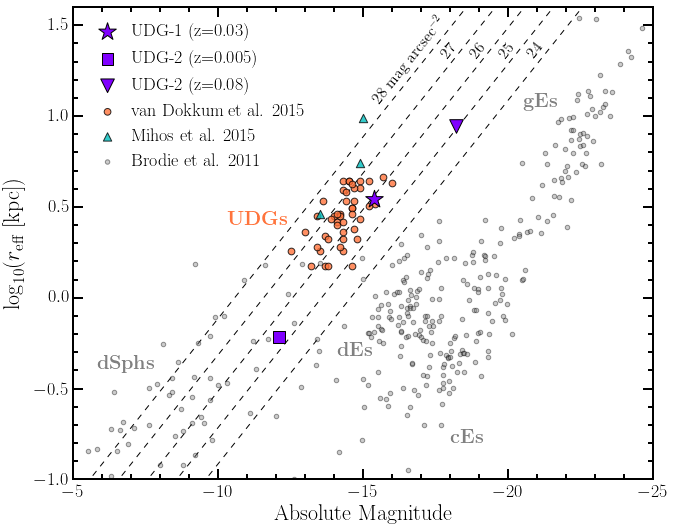

In [7]:
f, a = plt.subplots(figsize=(10,8))

# plot lines of constant effective surface brightness
reff_kpc = np.linspace(0.001,100,100)
reff_10pc_as = u.radian.to('arcsec')*1e3*reff_kpc/10.0
for sb in [24, 25, 26, 27, 28]:
    absmag = sb-2.5*np.log10(2*np.pi*reff_10pc_as**2)
    a.plot(absmag, np.log10(reff_kpc), 'k--', zorder=-200)
    
# plot my candidates
labels = ['UDG-1 (z=0.03)', 'UDG-2 (z=0.005)', 'UDG-2 (z=0.08)']
for i, m, s, l in zip(range(3), ['*', 's', 'v'], [340, 140, 185], labels):
    a.scatter(Mi_vals[i], np.log10(reff_vals[i]), marker=m, s=s, c=cmap(0), zorder=100, label=l)
    
# plot van Dokkum and Mihos
a.scatter(vanDokkum['Mg'], np.log10(vanDokkum['reff']), marker='o', s=45, edgecolors='k',
          alpha=0.8, color=cmap(0.85), label='van Dokkum et al. 2015')
a.scatter(mihos_MV, np.log10(mihos_reff), marker='^', s=70, c='c', alpha=0.8, label='Mihos et al. 2015')
a.scatter(brodie['M_V'], brodie['logr']+np.log10(1e-3), c='gray', alpha=0.4,
          zorder=-10, label='Brodie et al. 2011')
a.set_ylim(-1, 1.6)
a.set_xlim(-25,-5)
a.set_ylabel(r'$\log_{10}(r_\mathrm{eff}\ [\mathrm{kpc}])$')
a.set_xlabel(r'Absolute Magnitude')
a.minorticks_on()
a.invert_xaxis()
a.legend(loc='upper left', fontsize=18)

# get text rotation angle 
p1 = a.transData.transform_point((absmag[0], np.log10(reff_kpc)[0])) # convert from data 
p2 = a.transData.transform_point((absmag[1], np.log10(reff_kpc)[1])) # to screen coords
rot = np.degrees(np.arctan2(p2[1]-p1[1], p2[0]-p1[0]))

# add text to figure
x, dx, y = -17.6, -1, 1.3
fs = 15.5
a.text(-15.2, 1.05, r'28 mag arcsec$^{-2}$',rotation=rot, fontsize=fs, va='bottom')
a.text(x, y, '27',rotation=rot, fontsize=fs, va='bottom')
a.text(x+dx, y, '26',rotation=rot, fontsize=fs, va='bottom')
a.text(x+2*dx, y, '25',rotation=rot, fontsize=fs, va='bottom')
a.text(x+3*dx, y, '24',rotation=rot,fontsize=fs, va='bottom') 

a.text(-5.8, -.4, r'${\bf dSphs}$', color='gray', fontsize=20)
a.text(-10.3, .4, r'${\bf UDGs}$', color=cmap(0.85), fontsize=20)
a.text(-20.5, 1.05, r'${\bf gEs}$', color='gray', fontsize=20)
a.text(-18, -.8, r'${\bf cEs}$', color='gray', fontsize=20)
a.text(-14.1, -0.32, r'${\bf dEs}$', color='gray', fontsize=20)

f.savefig('../figures/gemini_FT_6-2016/size_vs_absmag.pdf');